In [1]:
from nptdms import TdmsFile as tdms
import glob, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from pathlib import Path
%matplotlib inline

def importCSV(filePath):
    dataFrame = pd.read_csv(filePath, header=0, low_memory=False)
    return dataFrame

def reIndex(DF):
    DF.reset_index(drop=True, inplace=True)
    return 0

def nullDrop(DF,col):
    return DF.dropna(subset=col)#DF[pd.notnull(DF[col])]

def dfDrop(DF,col,inPlace):
    if(inPlace):
        DF.drop(col, inplace=True, axis=1)
        return 0
    else:
        return DF.drop(col,axis=1)

def makeDict(value,key):
    myDict = value
    myDict.index = key
    return myDict.to_dict()

def tdmsToDF(topPath,fileNum):
    os.chdir(topPath)
    firstRun = True
    ind = 1
    xInd = 0
    for file in sorted(glob.glob("*.tdms")):
        if(firstRun):
            outputTDMS = tdms(topPath+file).as_dataframe()
            firstRun = False
        else:
            currentTDMS = tdms(topPath+file).as_dataframe()
            outputTDMS = outputTDMS.append(currentTDMS, ignore_index=True)
            ind = ind+1
        if(ind == 100):
            print('SAVE')
            xInd = xInd + 1
            outputTDMS = outputTDMS.rename(columns={outputTDMS.columns[0]: "Voltage_mV",
                                            outputTDMS.columns[1]: "Current_nA"})
            #path = Path(topPath+"part" + str(xInd) + ".npy")
            
            path = Path('/Users/Mus/Downloads/DNA/'+date+'/'+date+'_'+fileNum+'/'+'part' + str(xInd) + '.npy')
            
            if not os.path.exists('/Users/Mus/Downloads/DNA/'+date+'/'+date+'_'+fileNum+'/'):
                os.makedirs('/Users/Mus/Downloads/DNA/'+date+'/'+date+'_'+fileNum+'/')
            
            np.save(path,outputTDMS)
            ind = 1
            firstRun = True
    xInd = xInd + 1
    outputTDMS = outputTDMS.rename(columns={outputTDMS.columns[0]: "Voltage_mV",
                                            outputTDMS.columns[1]: "Current_nA"})
    #path = Path(topPath+"part" + str(xInd) + ".npy")
    path = Path('/Users/Mus/Downloads/DNA/'+date+'/'+date+'_'+fileNum+'/'+'part' + str(xInd) + '.npy')
    if not os.path.exists('/Users/Mus/Downloads/DNA/'+date+'/'+date+'_'+fileNum+'/'):
                os.makedirs('/Users/Mus/Downloads/DNA/'+date+'/'+date+'_'+fileNum+'/')
    np.save(path,outputTDMS)
    
    return xInd

def addTime(freqHz,DF):
    reIndex(DF)
    rows = DF.shape[0]
    cols = DF.shape[1]
    DF.insert(cols, "Time_s", np.linspace(0, (rows-1)/freqHz, num=rows))
    #DF.loc[DF["Time_s"]] = np.linspace(0, (rows-1)/freqHz, num=rows)
    #DF = DF.assign('Time_s'= np.linspace(0, (rows-1)/freqHz, num=rows))
    #DF.Time_s = np.linspace(0, (rows-1)/freqHz, num=rows)
    return DF

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

In [17]:
######### I/O
file = []   
date = '120517'
myTopFolder = "/Volumes/Seagate Backup Plus Drive/ExperimentData/Data/"+date+"/" #Data_Axopatch/"+date+"/"

########## Find all file suffix
os.chdir(myTopFolder)
for root, dirs, files in os.walk(myTopFolder, topdown=True):
    for name in dirs:
        nameSplit = name.split('_')
        if(nameSplit[0] != 'Frame'):
            if(len(name.split(date+'_'))>1):
                file.append(name.split(date+'_')[1])
#########################    
alreadyConverted = False
#######################################

In [18]:


Fs = 150000
file = [10,  11,  12,  13,  15,  16,  17,  18,  19,  20,  21,  22,  23,  7,  8,  9]

for x in file:
    #myDataFolder = "/Users/Mus/Downloads/"+date+"/"+date+"_"+str(x)+"/"
    myDataFolder = myTopFolder+date+"_"+str(x)+"/"
    myLocalDataFolder = "/Users/Mus/Downloads/DNA/"+date+"/"+date+"_"+str(x)+"/"
    
    if(alreadyConverted == True):
        os.chdir(myLocalDataFolder)
        fileCount = np.size(glob.glob("*.npy"))
    else:
        fileCount  = tdmsToDF(myDataFolder,str(x))
    
    for i in range(1,fileCount+1):
        
        data=np.load(Path(myLocalDataFolder+"part" + str(i) + ".npy"))
        
        if(data.shape[1]==4):
            myDF = pd.DataFrame(data=data,columns=["Voltage_mV","Current_nA","X","Y"])
            dfDrop(myDF,["X","Y"],1)
        elif(data.shape[1]==3):
            myDF = pd.DataFrame(data=data,columns=["Voltage_mV","Current_nA","X"])
            dfDrop(myDF,["X"],1)  
        else:
            myDF = pd.DataFrame(data=data,columns=["Voltage_mV","Current_nA"])

        ################    STEP 1
        ##### Create a bitmask using the voltage.

        back_roll = -int(Fs/150);
        forward_roll = int(Fs/150);

        vMask = myDF.Voltage_mV<np.mean(myDF.Voltage_mV)

        forward_vMask = np.roll(vMask, forward_roll)
        backward_vMask = np.roll(vMask, back_roll)
        backOR = np.logical_or(backward_vMask,vMask)
        forwardOR = np.logical_or(forward_vMask,vMask)

        vMask = np.logical_or(backOR,forwardOR)
        vMask = np.invert(vMask)

        myDF = myDF[vMask]

        reIndex(myDF)

        ################## STEP 2
        ##### Remove Baseline by LPF

        high_b, high_a =signal.butter(4,0.09, btype='highpass')
        #myDF["HPF"] = signal.filtfilt(high_b, high_a, myDF["Current_nA"], padlen=150)
        
        if(myDF["Current_nA"].size<100):
                pad = myDF["Current_nA"].size-1
        else:
            pad = 150
            
        low_b, low_a =signal.butter(4,0.9, btype='lowpass')
        myDF["LPF"] = signal.filtfilt(high_b, high_a, myDF["Current_nA"], padlen=pad)


        ################## STEP 3
        ##### Remove Extraordinary regions

        myDF = myDF[np.logical_and(myDF.LPF<0.25, myDF.LPF>-0.25)]
        addTime(Fs,myDF)


        ########### STEP 4
        ##### Find peaks with promience on LPF

        peaks, _ = signal.find_peaks(-myDF.Current_nA, 
                                     prominence=(0.1), 
                                     distance=0.1*Fs) 
                                     #width=0.001*Fs)

        newPeaks = peaks[myDF.Current_nA[peaks]<(np.mean(myDF.Current_nA)*0.99)]

        #0.001s is quickest, therefore, 0.001*Fs is the distance and width


        ########## STEP 5
        ## Calculate the peak duration then we'll get rid of the peaks which don't make sense. 


        # Aggresively filter signal using LPF Butterworth
        ########## Undesirable transients. Use scipy filter instead
        #order = 3
        #cutoff = 1000 
        #b, a = butter_lowpass(cutoff, Fs, order)
        #y = butter_lowpass_filter(peaks[1], cutoff, Fs, order)
        ###############

        b, a = signal.butter(4, 0.01)

        #Could replace with comprehension, but this is more legible
        if(i==1):
            depths = []
        z =1
        for pk in newPeaks:

            rollInd = int(Fs*0.01)
            peak_x = myDF["Time_s"][pk-rollInd:pk+rollInd]
            peak_y = myDF["Current_nA"][pk-rollInd:pk+rollInd]
            reIndex(peak_x)
            reIndex(peak_y)
            
            if(myDF["Current_nA"].size<100):
                pad = myDF["Current_nA"].size-1
            else:
                pad = 150
            
            if(peak_y.shape[0]==0):
                print('Empty peak')
            else: 
                if(peak_y.size<100):
                    pad2 = peak_y.size-1
                else:
                    pad2 = 100
                    
                y = signal.filtfilt(b, a, peak_y, padlen=pad2)

                gradY = np.gradient(y)

                
                ########### EXPERIMENTAL
                
                peaksPos, _ = signal.find_peaks(gradY,prominence=(0.0001))
                peaksNeg, _ = signal.find_peaks(-gradY,prominence=(0.0001))

                mArr = gradY[peaksPos][gradY[peaksPos]>abs(np.mean(gradY)*100)]
                
                if(mArr.size!=0):
                    mPeakPos = np.asscalar(np.argwhere(gradY == mArr[mArr.size-1]))
                    endIndex = mPeakPos
                else:
                    endIndex = int(np.argmax(gradY))
                    
                
                mArr = gradY[peaksNeg][abs(gradY[peaksNeg])>abs(np.mean(gradY)*100)]
                
                if(mArr.size!=0):
                    mPeakNeg = np.asscalar(np.argwhere(gradY == mArr[0]))
                    startIndex = mPeakNeg
                else:
                    startIndex = int(np.argmin(gradY))
                    
                
                
                ############################################
                
                
                if(endIndex<startIndex):
                    temp = endIndex
                    endIndex = startIndex
                    startIndex = endIndex

                endIndex = int(endIndex*1.03)
                startIndex = int(startIndex*0.97)

                if(startIndex<0):
                    startIndex=0
                if(endIndex>=peak_x.shape[0]):
                    endIndex=peak_x.shape[0]-1

                depth = (peak_y[startIndex:endIndex].min() - peak_y[startIndex])*-1000
                duration = (peak_x[endIndex] - peak_x[startIndex])*1000
                
                ################ AREA
                square_height = peak_y.max()#(peak_y.max()-peak_y.min())
                square_width = (peak_x.max()-peak_x.min())
                square_area = square_height*square_width
                trapzArea = np.trapz(peak_y, peak_x)
                ecd = square_area - trapzArea
                ########################
                
                ################New Area
                
                square_area = peak_y.max()*duration
                trapzArea = np.trapz(peak_y[startIndex:endIndex], peak_x[startIndex:endIndex])
                ecd = square_area - trapzArea
        
                #plt.plot(peak_x,peak_y)
                #plt.plot(peak_x[startIndex],peak_y[startIndex],'x')
                #plt.plot(peak_x[endIndex],peak_y[endIndex],'o')

                #plt.axhline(y=peak_y[startIndex:endIndex].min(),color='red')
                #plt.axhline(y=peak_y[startIndex],color='red')

                #plt.axvline(x=peak_x[endIndex],color='black')
                #plt.axvline(x=peak_x[startIndex],color='black')

                #plt.savefig(myDataFolder+'goodPeaks_'+ str(z)+'.png')
                #plt.clf()
                #z=z+1

                #if(duration<5):
                depths.append([depth,duration,ecd])
    
    if not os.path.exists('/Users/Mus/Downloads/DNA/'+date+'/goodPeaks/'):
        os.makedirs('/Users/Mus/Downloads/DNA/'+date+'/goodPeaks/')
    
    depthDur = pd.DataFrame(list(depths),columns =['depth', 'duration', 'ecd'])
    path = Path('/Users/Mus/Downloads/DNA/'+date+'/goodPeaks/'+'goodPeaks_'+ str(x)+'.npy')
    np.save(path,depthDur)
    print('SAVE PEAKS DONE')



SAVE
SAVE
SAVE
SAVE
SAVE
SAVE
SAVE
SAVE
SAVE


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:135: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:144: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Empty peak
SAVE PEAKS DONE
SAVE
SAVE PEAKS DONE
SAVE
SAVE
SAVE
SAVE
SAVE
SAVE
SAVE
SAVE
Empty peak
SAVE PEAKS DONE
SAVE PEAKS DONE
SAVE
SAVE PEAKS DONE
SAVE
SAVE PEAKS DONE
SAVE
Empty peak
SAVE PEAKS DONE
SAVE PEAKS DONE
SAVE
SAVE
SAVE
SAVE
SAVE PEAKS DONE
SAVE
SAVE
SAVE
SAVE
SAVE PEAKS DONE
SAVE PEAKS DONE
SAVE
SAVE
SAVE
SAVE
SAVE
SAVE
SAVE
SAVE
SAVE PEAKS DONE
SAVE
SAVE PEAKS DONE
SAVE PEAKS DONE
SAVE PEAKS DONE
SAVE PEAKS DONE


In [22]:
################# STEP 6
####### Combine all 'goodpeaks' into a plot

goodPeaksPath = ('/Users/Mus/Downloads/DNA/'+date+'/goodPeaks/')
constrain = False

os.chdir(goodPeaksPath)
for file in sorted(glob.glob("*.npy")):
    depths = []
    
    np_load_old = np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
    depths.extend(np.load(Path(goodPeaksPath+file)).tolist())
    np.load = np_load_old
    
    depthDur = pd.DataFrame(list(depths),columns =['depth', 'duration','ecd'])
    
    if(constrain==True):
        depthDur = depthDur[depthDur.depth<600]
        depthDur = depthDur[depthDur.depth>80]
        depthDur = depthDur[depthDur.duration>0.5]
        depthDur = depthDur[depthDur.duration<6]    
        depthDur = depthDur[depthDur.ecd>15]
        depthDur = depthDur[depthDur.ecd<200]
    
    plt.plot(depthDur.duration,-depthDur.depth,'x') 
    plt.savefig(goodPeaksPath+file+'_Plot.png')
    plt.clf()
    
    plt.hist(depthDur.ecd,bins=50,log=True)
    plt.savefig(goodPeaksPath+file+'_Hist.png')
    plt.clf()

#plt.plot(myDF.Current_nA)
#plt.plot(newPeaks,myDF.Current_nA[newPeaks],'o')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


<Figure size 432x288 with 0 Axes>

In [ ]:
################################################################################
################################################################################
####################    DONT TOUCH.  OLD   BACKUP     ##########################
################################################################################
################################################################################

In [ ]:
for i in range(1,fileCount+1):
    myDF = pd.DataFrame(data=np.load(Path(myDataFolder+"part" + str(i) + ".npy")), 
                        columns=["Voltage_mV","Current_nA"])
    
    ################    STEP 1
    ##### Create a bitmask using the voltage.

    back_roll = -int(Fs/150);
    forward_roll = int(Fs/150);

    vMask = myDF.Voltage_mV<np.mean(myDF.Voltage_mV)

    forward_vMask = np.roll(vMask, forward_roll)
    backward_vMask = np.roll(vMask, back_roll)
    backOR = np.logical_or(backward_vMask,vMask)
    forwardOR = np.logical_or(forward_vMask,vMask)

    vMask = np.logical_or(backOR,forwardOR)
    vMask = np.invert(vMask)

    myDF = myDF[vMask]

    reIndex(myDF)

    ################## STEP 2
    ##### Remove Baseline by LPF

    high_b, high_a =signal.butter(4,0.09, btype='highpass')
    #myDF["HPF"] = signal.filtfilt(high_b, high_a, myDF["Current_nA"], padlen=150)

    low_b, low_a =signal.butter(4,0.9, btype='lowpass')
    myDF["LPF"] = signal.filtfilt(high_b, high_a, myDF["Current_nA"], padlen=150)
    
    
    ################## STEP 3
    ##### Remove Extraordinary regions

    myDF = myDF[np.logical_and(myDF.LPF<0.25, myDF.LPF>-0.25)]
    addTime(Fs,myDF)
    

    ########### STEP 4
    ##### Find peaks with promience on LPF

    peaks, _ = signal.find_peaks(-myDF.Current_nA, 
                                 prominence=(0.1), 
                                 distance=0.1*Fs) 
                                 #width=0.001*Fs)

    newPeaks = peaks[myDF.Current_nA[peaks]<(np.mean(myDF.Current_nA)*0.99)]

    #0.001s is quickest, therefore, 0.001*Fs is the distance and width
    
    
    ########## STEP 5
    ## Calculate the peak duration then we'll get rid of the peaks which don't make sense. 


    # Aggresively filter signal using LPF Butterworth
    ########## Undesirable transients. Use scipy filter instead
    #order = 3
    #cutoff = 1000 
    #b, a = butter_lowpass(cutoff, Fs, order)
    #y = butter_lowpass_filter(peaks[1], cutoff, Fs, order)
    ###############

    b, a = signal.butter(4, 0.01)

    #Could replace with comprehension, but this is more legible
    if(i==1):
        depths = []
    z =1
    for pk in newPeaks:

        rollInd = int(Fs*0.01)
        peak_x = myDF["Time_s"][pk-rollInd:pk+rollInd]
        peak_y = myDF["Current_nA"][pk-rollInd:pk+rollInd]
        reIndex(peak_x)
        reIndex(peak_y)

        if(peak_y.shape[0]==0):
            print('Empty peak')
        else:
            y = signal.filtfilt(b, a, peak_y, padlen=100)

            gradY = np.gradient(y)

            endIndex = int(np.argmax(gradY))
            startIndex = int(np.argmin(gradY))

            if(endIndex<startIndex):
                temp = endIndex
                endIndex = startIndex
                startIndex = endIndex

            endIndex = int(endIndex*1.03)
            startIndex = int(startIndex*0.97)

            if(startIndex<0):
                startIndex=0
            if(endIndex>=peak_x.shape[0]):
                endIndex=peak_x.shape[0]-1
            
            depth = (peak_y[startIndex:endIndex].min() - peak_y[startIndex])*-1000
            duration = (peak_x[endIndex] - peak_x[startIndex])*1000
            
            plt.plot(peak_x,peak_y)
            plt.plot(peak_x[startIndex],peak_y[startIndex],'x')
            plt.plot(peak_x[endIndex],peak_y[endIndex],'o')
            
            plt.axhline(y=peak_y[startIndex:endIndex].min(),color='red')
            plt.axhline(y=peak_y[startIndex],color='red')
            
            plt.axvline(x=peak_x[endIndex],color='black')
            plt.axvline(x=peak_x[startIndex],color='black')
            
            plt.savefig(myDataFolder+'goodPeaks_'+ str(z)+'.png')
            plt.clf()
            z=z+1

            #if(duration<5):
            depths.append([depth,duration])

depthDur = pd.DataFrame(list(depths),columns =['depth', 'duration'])
path = Path(myDataFolder+'goodPeaks_'+ str(i)+'.npy')
np.save(path,depthDur)
print('SAVE PEAKS '+str(i))

In [ ]:
################################################################################
################################################################################
############### Signal Processing that is no longer yet used. ##################
################################################################################
################################################################################

In [ ]:
# LPF Butterworth

order = 3
cutoff = 10000 
b, a = butter_lowpass(cutoff, Fs, order)

y = butter_lowpass_filter(cutDF["Current_nA"], cutoff, Fs, order)

cutDF["Filtered_Current"] = y;
cutDF = cutDF[100:]

plt.plot(cutDF["Time_s"],cutDF["Filtered_Current"])

In [ ]:
f, t, Zxx = signal.stft(y, Fs, nperseg=1000)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=0.0006)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
f, t, Zxx = signal.stft(cutDF["Current_nA"][1:], Fs, nperseg=1000)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=0.006)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
################################################################################
################################################################################
################################ Playground ####################################
################################################################################
################################################################################

In [3]:

Fs = 150000
file = [24]
i = 1

myDataFolder = myTopFolder+date+"_"+str(file[0])+"/"
myLocalDataFolder = "/Users/Mus/Downloads/DNA/"+date+"/"+date+"_"+str(file[0])+"/"


os.chdir(myDataFolder)
fileCount = np.size(glob.glob("*.npy"))




data=np.load(Path(myLocalDataFolder+"part" + str(i) + ".npy"))

if(data.shape[1]==4):
    myDF = pd.DataFrame(data=data,columns=["Voltage_mV","Current_nA","X","Y"])
    dfDrop(myDF,["X","Y"],1)
elif(data.shape[1]==3):
    myDF = pd.DataFrame(data=data,columns=["Voltage_mV","Current_nA","X"])
    dfDrop(myDF,["X"],1)  
else:
    myDF = pd.DataFrame(data=data,columns=["Voltage_mV","Current_nA"])

################    STEP 1
##### Create a bitmask using the voltage.

back_roll = -int(Fs/150);
forward_roll = int(Fs/150);

vMask = myDF.Voltage_mV<np.mean(myDF.Voltage_mV)

forward_vMask = np.roll(vMask, forward_roll)
backward_vMask = np.roll(vMask, back_roll)
backOR = np.logical_or(backward_vMask,vMask)
forwardOR = np.logical_or(forward_vMask,vMask)

vMask = np.logical_or(backOR,forwardOR)
vMask = np.invert(vMask)

myDF = myDF[vMask]

reIndex(myDF)

################## STEP 2
##### Remove Baseline by LPF

high_b, high_a =signal.butter(4,0.09, btype='highpass')
#myDF["HPF"] = signal.filtfilt(high_b, high_a, myDF["Current_nA"], padlen=150)

if(myDF["Current_nA"].size<100):
        pad = myDF["Current_nA"].size-1
else:
    pad = 150

low_b, low_a =signal.butter(4,0.9, btype='lowpass')
myDF["LPF_temp"] = signal.filtfilt(high_b, high_a, myDF["Current_nA"], padlen=pad)


################## STEP 3
##### Remove Extraordinary regions

myDF = myDF[np.logical_and(myDF.LPF<0.25, myDF.LPF>-0.25)]
addTime(Fs,myDF)


########### STEP 4
##### Find peaks with promience on LPF

peaks, _ = signal.find_peaks(-myDF.Current_nA, 
                             prominence=(0.1), 
                             distance=0.1*Fs) 
                             #width=0.001*Fs)

newPeaks = peaks[myDF.Current_nA[peaks]<(np.mean(myDF.Current_nA)*0.99)]

#0.001s is quickest, therefore, 0.001*Fs is the distance and width



In [13]:
plt.plot(myDF.Time_s,myDF.Current_nA)
plt.plot(myDF.Time_s[peaks],myDF.Current_nA[peaks],'o')
#plt.plot(myDF.Time_s,myDF.LPF_temp)
plt.savefig(myLocalDataFolder+'goodPeaks_'+ str(file)+'_'+str(z)+'.png')
plt.clf()
z=z+1

<Figure size 432x288 with 0 Axes>

In [127]:
########## STEP 5
## Calculate the peak duration then we'll get rid of the peaks which don't make sense. 


# Aggresively filter signal using LPF Butterworth
########## Undesirable transients. Use scipy filter instead
#order = 3
#cutoff = 1000 
#b, a = butter_lowpass(cutoff, Fs, order)
#y = butter_lowpass_filter(peaks[1], cutoff, Fs, order)
###############

b, a = signal.butter(4, 0.01)

#Could replace with comprehension, but this is more legible
depths = []
z =1
for pk in newPeaks:

    rollInd = int(Fs*0.01)
    peak_x = myDF["Time_s"][pk-rollInd:pk+rollInd]
    peak_y = myDF["Current_nA"][pk-rollInd:pk+rollInd]
    reIndex(peak_x)
    reIndex(peak_y)

    if(myDF["Current_nA"].size<100):
        pad = myDF["Current_nA"].size-1
    else:
        pad = 150

    if(peak_y.shape[0]==0):
        print('Empty peak')
    else: 
        if(peak_y.size<100):
            pad2 = peak_y.size-1
        else:
            pad2 = 100

        y = signal.filtfilt(b, a, peak_y, padlen=pad2)

        gradY = np.gradient(y)

        endIndex = int(np.argmax(gradY))
        startIndex = int(np.argmin(gradY))

        if(endIndex<startIndex):
            temp = endIndex
            endIndex = startIndex
            startIndex = endIndex

        endIndex = int(endIndex*1.03)
        startIndex = int(startIndex*0.97)

        if(startIndex<0):
            startIndex=0
        if(endIndex>=peak_x.shape[0]):
            endIndex=peak_x.shape[0]-1

        depth = (peak_y[startIndex:endIndex].min() - peak_y[startIndex])*-1000
        duration = (peak_x[endIndex] - peak_x[startIndex])*1000

        ################ AREA
        square_height = peak_y.max()#(peak_y.max()-peak_y.min())
        square_width = (peak_x.max()-peak_x.min())
        
        square_area = depth*duration
        trapzArea = np.trapz(peak_y[startIndex:endIndex], peak_x[startIndex:endIndex])
        ecd = square_area - trapzArea

        plt.plot(peak_x,peak_y)
        plt.plot(peak_x[startIndex],peak_y[startIndex],'x')
        plt.plot(peak_x[endIndex],peak_y[endIndex],'o')

        plt.axhline(y=peak_y[startIndex:endIndex].min(),color='red')
        plt.axhline(y=peak_y[startIndex],color='red')

        plt.axvline(x=peak_x[endIndex],color='black')
        plt.axvline(x=peak_x[startIndex],color='black')

        plt.savefig(myLocalDataFolder+'goodPeaks_'+ str(z)+'.png')
        plt.clf()
        z=z+1

        #if(duration<5):
        depths.append([depth,duration,ecd])

#if not os.path.exists('/Users/Mus/Downloads/DNA/'+date+'/goodPeaks/'):
#os.makedirs('/Users/Mus/Downloads/DNA/'+date+'/goodPeaks/')

#depthDur = pd.DataFrame(list(depths),columns =['depth', 'duration', 'ecd'])
#path = Path('/Users/Mus/Downloads/DNA/'+date+'/goodPeaks/'+'goodPeaks_'+ str(x)+'.npy')
#np.save(path,depthDur)
#print('SAVE PEAKS DONE')

<Figure size 432x288 with 0 Axes>

In [15]:
################## To look at one peak

pk = newPeaks[11]

rollInd = int(Fs*0.01)
peak_x = myDF["Time_s"][pk-rollInd:pk+rollInd]
peak_y = myDF["Current_nA"][pk-rollInd:pk+rollInd]
reIndex(peak_x)
reIndex(peak_y)

if(myDF["Current_nA"].size<100):
    pad = myDF["Current_nA"].size-1
else:
    pad = 150

if(peak_y.shape[0]==0):
    print('Empty peak')
else: 
    if(peak_y.size<100):
        pad2 = peak_y.size-1
    else:
        pad2 = 100

    y = signal.filtfilt(b, a, peak_y, padlen=pad2)

    gradY = np.gradient(y)

    endIndex = int(np.argmax(gradY))
    startIndex = int(np.argmin(gradY))

    if(endIndex<startIndex):
        temp = endIndex
        endIndex = startIndex
        startIndex = endIndex

    endIndex = int(endIndex*1.03)
    startIndex = int(startIndex*0.97)

    if(startIndex<0):
        startIndex=0
    if(endIndex>=peak_x.shape[0]):
        endIndex=peak_x.shape[0]-1

    depth = (peak_y[startIndex:endIndex].min() - peak_y[startIndex])*-1000
    duration = (peak_x[endIndex] - peak_x[startIndex])*1000

    ################ AREA
    square_height = peak_y.max()#(peak_y.max()-peak_y.min())
    square_width = (peak_x.max()-peak_x.min())
    square_area = square_height*square_width
    trapzArea = np.trapz(peak_y, peak_x)
    ecd = square_area - trapzArea


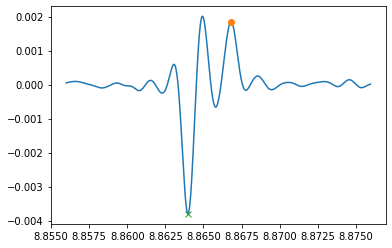

In [115]:
plt.plot(peak_x,gradY)
plt.plot(peak_x[mPeakPos],gradY[mPeakPos],'o')
plt.plot(peak_x[mPeakNeg],gradY[mPeakNeg],'x')


In [25]:
plt.plot(peak_x,gradY)
plt.savefig(myLocalDataFolder+'goodPeaks_12_3.png')
plt.clf()

<Figure size 432x288 with 0 Axes>

In [108]:
peaksPos, _ = signal.find_peaks(gradY,prominence=(0.0001))
peaksNeg, _ = signal.find_peaks(-gradY,prominence=(0.0001))

In [114]:
peaksPos, _ = signal.find_peaks(gradY,prominence=(0.0001))
peaksNeg, _ = signal.find_peaks(-gradY,prominence=(0.0001))

mArr = gradY[peaksPos][gradY[peaksPos]>abs(np.mean(gradY)*100)]
mPeakPos = np.asscalar(np.argwhere(gradY == mArr[mArr.size-1]))

mArr = gradY[peaksNeg][abs(gradY[peaksNeg])>abs(np.mean(gradY)*100)]
mPeakNeg = np.asscalar(np.argwhere(gradY == mArr[0]))


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """


In [109]:
gradY[peaksNeg]

array([-9.78208988e-05, -1.76927602e-04, -2.50649355e-04, -3.80357179e-03,
       -6.60967519e-04, -1.66473368e-04, -1.49570877e-04, -5.22389470e-05,
       -5.82402321e-05, -8.98096271e-05])

In [111]:
abs(np.mean(gradY)*100)

0.00027058937633649783